In [1]:
from xml.etree import ElementTree #tparsing XML annotations


from mrcnn.config import Config #config class object
from mrcnn.model import MaskRCNN #maskRcnn
from mrcnn.utils import Dataset #Dataset class


# split into train and test set
from os import listdir
from numpy import zeros
from numpy import asarray

from matplotlib import pyplot

from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image


/home/vasco/anaconda3/envs/colab/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vasco/anaconda3/envs/colab/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vasco/anaconda3/envs/colab/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vasco/anaconda3/envs/colab/lib/python3.7/site-

# Loading Dataset

In [3]:
# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

b,w,h= extract_boxes("/home/vasco/BeachSafe/Dataset/annots/scene00541.xml")
print(b,w,h)

[[1310, 341, 1347, 405], [1205, 320, 1241, 430]] 1920 1442


# Creating Dataset object (mandatory for this MaskRCnn library)

In [9]:


# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir,is_train=True):
        # define one class
        self.add_class("dataset", 1, "person")
        # define data locations
        images_dir = dataset_dir + '/imgs/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        iteration=0
        for filename in listdir(images_dir):
            # extract image id
            iteration+=1
            image_id = filename[:-4]
            print(image_id)
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and iteration >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and iteration < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('person'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
   
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
    
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

# Train-Test Split
## First 150 images used for training // change when using other dataset

In [10]:
# train set

train_set = KangarooDataset()
train_set.load_dataset('/home/vasco/BeachSafe/Dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
#test_set = KangarooDataset()
#test_set.load_dataset('kangaroo', is_train=False)
#test_set.prepare()
#print('Test: %d' % len(test_set.image_ids))

duquesa401801
duquesa403241
duquesa200001
duquesa2
scene01621
duquesa200781
duquesa400181
duquesa402521
s3
duquesa200721
duquesa302701
duquesa300181
duquesa403061
duquesa400901
s2
scene01441
duquesa200661
duquesa200301
duquesa1
s7
scene01981
scene02881
duquesa301441
duquesa200181
duquesa400001
duquesa302341
duquesa3
duquesa200481
duquesa400721
duquesa403421
duquesa200421
duquesa300901
duquesa200061
scene01261
scene00181
s6
duquesa201681
duquesa402881
scene00001
duquesa301261
duquesa201321
duquesa200361
s1
duquesa402701
duquesa401261
duquesa200601
scene03241
duquesa200541
duquesa200841
duquesa401621
scene01801
duquesa201861
s4
scene00541
duquesa200241
scene02341
scene00361
duquesa300001
duquesa200121
s5
duquesa201621
duquesa402341
scene01081
Train: 63


# Testing the Dataset object

(1442, 1920, 3)
6


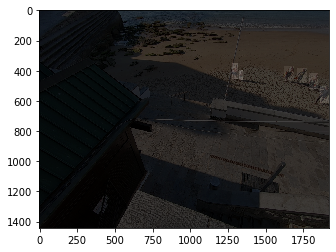

In [18]:

# load an image
image_id = 4
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape[-1])
pyplot.imshow(image)
for j in range(mask.shape[2]):
    pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.2)

# plot image

# plot mask
#pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

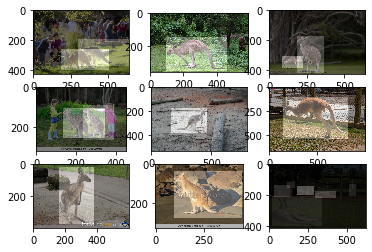

In [19]:
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    image = train_set.load_image(i)
    pyplot.imshow(image)
    # plot all masks
    mask, _ = train_set.load_mask(i)
    for j in range(mask.shape[2]):
        pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
    # show the figure
pyplot.show()

In [21]:
# enumerate all images in the dataset
for image_id in train_set.image_ids:
    # load image info
    info = train_set.image_info[image_id]
    # display on the console


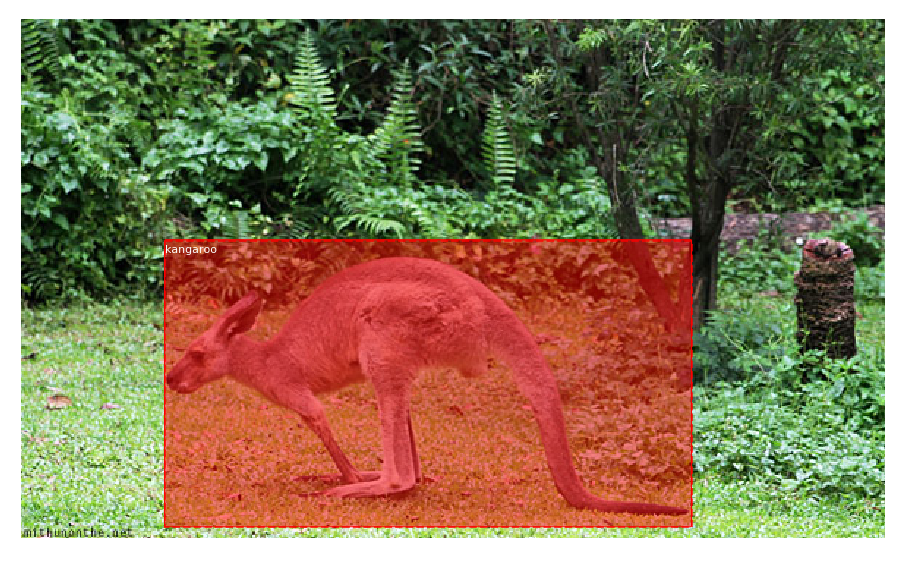

In [25]:
# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

# Creating class configuration object

In [29]:

# define a configuration for the model
class KangarooConfig(Config):
    # Give the configuration a recognizable name
    NAME = "kangaroo_cfg"
    # Number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131

# prepare config
config = KangarooConfig()

# Training the model

#### lr = 0.001
#### change layer argument to "all" to train all weights
#### "custom_callbacks" argument for using keras callbacks

In [ ]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead

Starting at epoch 0. LR=0.001

Checkpoint Path: ./kangaroo_cfg20200519T1427/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_

/home/vasco/anaconda3/envs/colab/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/vasco/anaconda3/envs/colab/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/vasco/anaconda3/envs/colab/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/vasco/anaconda3/envs/colab/lib/python3.7/site-packages/keras/engine/training_generator.p



Epoch 1/5


# Evaluating the model

In [30]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP


# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)